In [1]:
!pip install abtem numpy==1.26.4
!uv pip install -q --system numba-cuda==0.4.0
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [3]:
import ase
import ase.io
import numpy as np
import sys
import matplotlib.pyplot as plt
import abtem

# sys.path.append('../..')
# lufeo3 = ase.io.read("../../data/structures/LFO_LS.cif")
lufeo3 = ase.io.read("LFO_LS.cif")

## STEM Walkthrough

In [4]:
abtem.config.set({"device": "cpu", "fft": "fftw"})
abtem.config.set({"device": "gpu"})

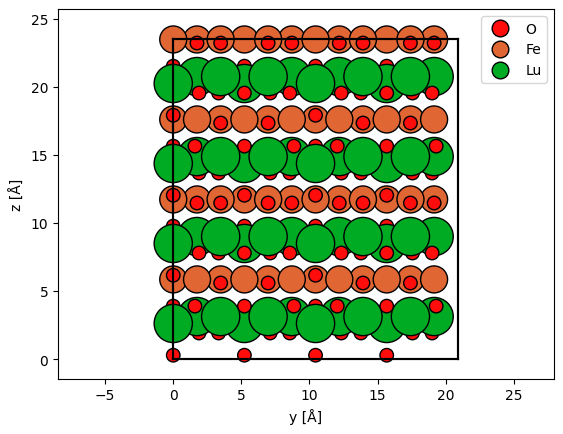

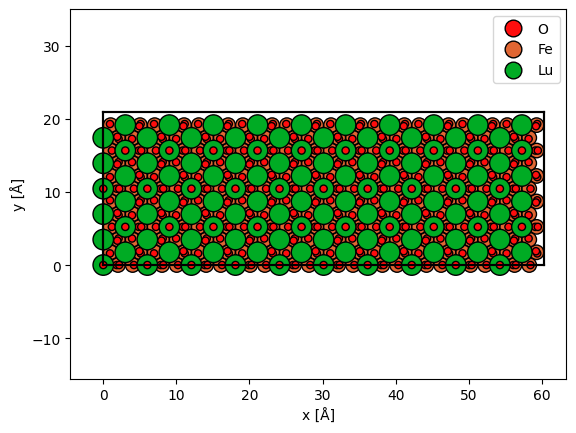

In [26]:
atoms = abtem.orthogonalize_cell(lufeo3)

atoms *= (10, 2, 2)
abtem.show_atoms(atoms, plane="yz", legend=True);
abtem.show_atoms(atoms, plane="xy", legend=True);

In [27]:
frozen_phonons = abtem.FrozenPhonons(atoms, 8, sigmas=0.1)

In [28]:
potential = abtem.Potential(frozen_phonons, sampling=0.05, plane='yz')

In [29]:
probe = abtem.Probe(energy=100e3, semiangle_cutoff=25, Cs=10e4, defocus="scherzer")
probe.grid.match(potential)

print(f"defocus = {probe.aberrations.defocus} Å")
print(f"FWHM = {probe.profiles().width().compute()} Å")

defocus = 74.51278341794487 Å
FWHM = 0.7976745963096619 Å


[########################################] | 100% Completed | 101.76 ms
[########################################] | 100% Completed | 108.67 ms


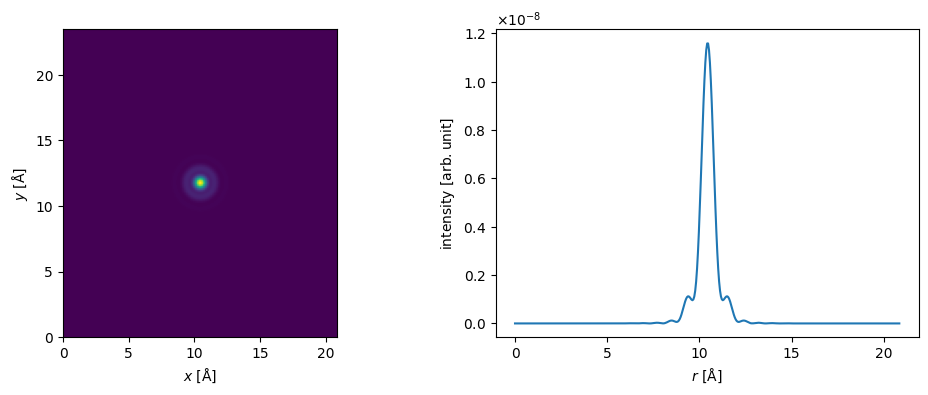

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(ax=ax1)
probe.profiles().show(ax=ax2);

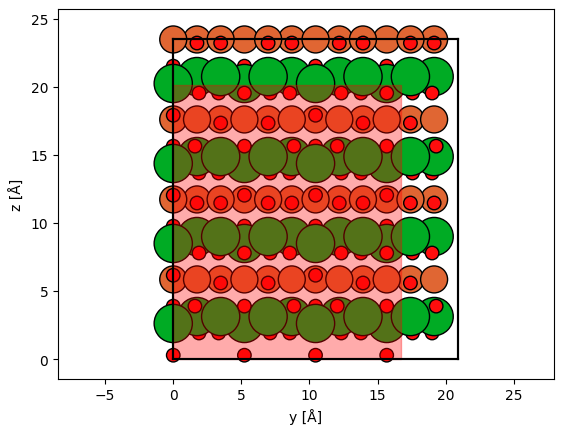

In [31]:
grid_scan = abtem.GridScan(
    start=(0, 0),
    end=(4/5, 6/7),
    sampling=probe.aperture.nyquist_sampling,
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(atoms, plane="yz")

grid_scan.add_to_plot(ax)

In [32]:
detector = abtem.FlexibleAnnularDetector()

In [34]:
flexible_measurement = probe.scan(potential, scan=grid_scan, detectors=detector)

flexible_measurement.compute()

[########################################] | 100% Completed | 435.28 s


In [35]:
bf_measurement = flexible_measurement.integrate_radial(0, probe.semiangle_cutoff)
maadf_measurement = flexible_measurement.integrate_radial(50, 150)
haadf_measurement = flexible_measurement.integrate_radial(90, 200)

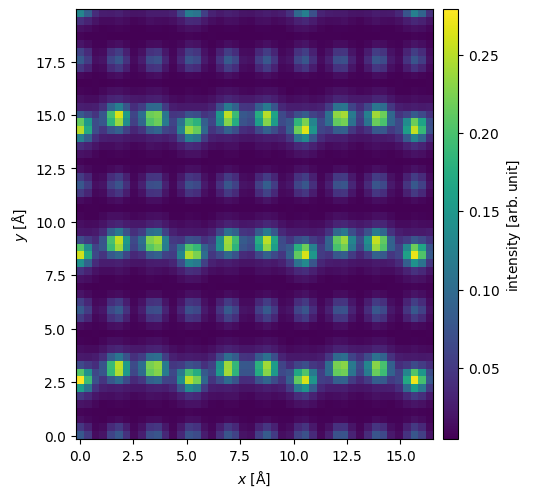

In [36]:
haadf_measurement.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

In [37]:
interpolated_measurements = haadf_measurement.interpolate(0.05)
filtered_measurements = interpolated_measurements.gaussian_filter(0.3)

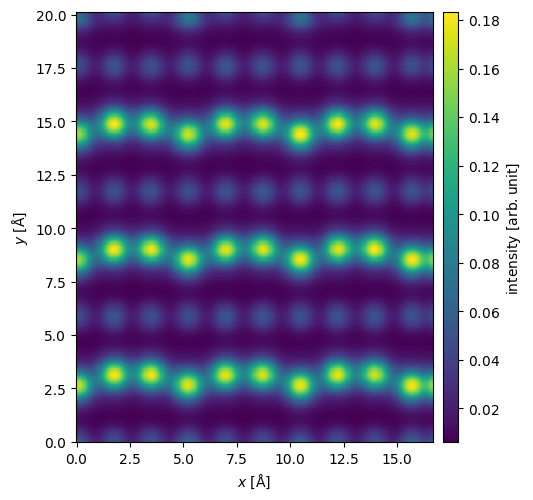

In [38]:
filtered_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

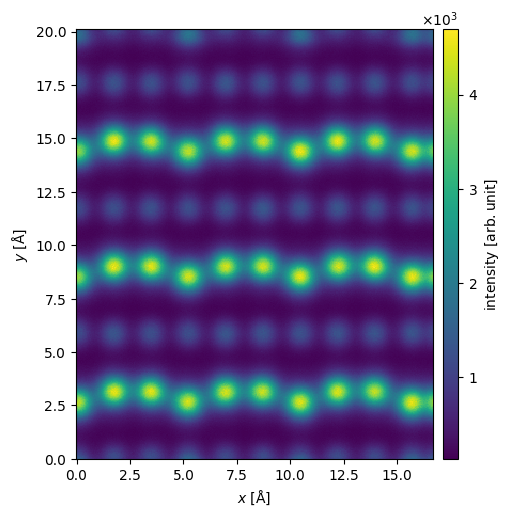

In [39]:
noisy_measurements = filtered_measurements.poisson_noise(dose_per_area=1e7)

noisy_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

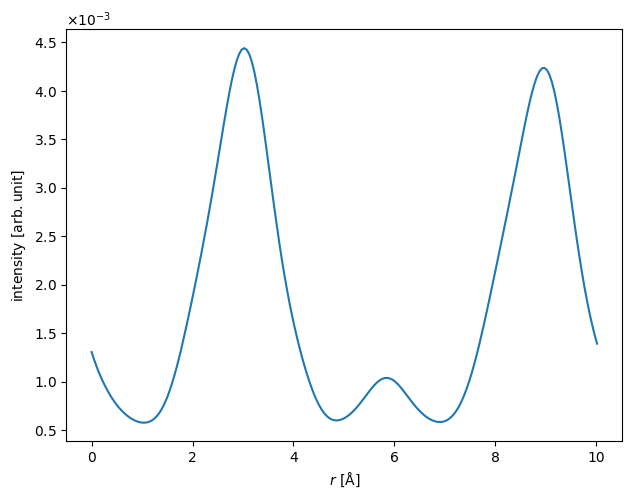

In [19]:
line_profile = filtered_measurements.interpolate_line(
    start=(1 / 2, 0), end=(1 / 2, 1), fractional=True
)

line_profile.show();